# Evaluating performance

This file applies the strategy from `wordle_solver.ipynb` to all possible words and creates histograms to show the results. There is one key difference between the implementation in this file and the one in `wordle_solver.ipynb`. Here, we pre-compute and cache all possible measurements of word pairs, which saves time later when we have to run the strategy repeatedly on all words in the dictionary.

In [2]:
using PyPlot
# For @showprogress
using ProgressMeter
# for prop, freqtable
using FreqTables
# for mean
using Statistics

In [3]:
function parse_word_list(filename::String)::Vector{String}
    s = open(filename) do file
        read(file, String)
    end
    s = replace(s, '\"' => "")
    return split(s, ", ")
end;

In [4]:
# list of words that can potentially be solutions
solutions = parse_word_list("solutions.txt")

# list of words that are valid guesses, but will never be solutions
nonsolutions = parse_word_list("nonsolutions.txt")

# all possible valid guesses
largelist = [nonsolutions; solutions]
;

In [5]:
function measure_word(word1::String, word2::String)::Int64
    s = 0
    for i = 1:5
        s *= 10
        if word1[i] == word2[i]
            s += 2
        elseif word1[i] in word2
            s += 1
        else
            s += 0
        end
    end
    return s
end

# return entropy of distribution of group_sizes (we want this to be large!)
function get_entropy(group_sizes::Vector{Int64})::Float64
    pmf = group_sizes/sum(group_sizes)
    return sum( -p*log(p) for p in pmf )
end;

### Pre-cache measurements for all word pairs

In [6]:
# cache measurements for all possible pairs of words (this saves time down the road)
@time begin
    wordscores = Dict{String, Int64}()
    for w1 in largelist
        for w2 in solutions
            wordscores[w1*w2] = measure_word(w1,w2)
        end
    end
end;

 32.910933 seconds (96.89 M allocations: 4.461 GiB, 32.37% gc time)


### Enum to describe different possible heuristics

In [7]:
Base.Enums.@enum Heuristic begin
    PRIORITIZE_ENTROPY = 1
    PRIORITIZE_MAX_GROUP_SIZE = 2
end

### Optimized helper functions using the cached measurements

In [8]:
# returns the sizes of the groups of words in `solution_pool` that have the same
# response when the guessed word is `guessed_word`.
function get_group_sizes(
    guessed_word::String,
    solution_pool::Vector{String}
)::Vector{Int64}
    out = Dict{Int64, Int64}()
    for wc in solution_pool
        s = wordscores[guessed_word*wc]
        if haskey(out, s)
            out[s] += 1
        else
            out[s] = 1
        end
    end
    return collect(values(out))
end

function find_move(
    candidate_pool::Vector{String}, 
    solution_pool::Vector{String};
    heuristic::Heuristic = PRIORITIZE_ENTROPY
)::String
    group_sizes::Vector{Vector{Int64}} = map(w -> get_group_sizes(w, solution_pool), candidate_pool)
    maximum_group_size::Vector{Int64} = map(maximum, group_sizes)
    entropy::Vector{Float64} = map(get_entropy, group_sizes)
    is_potential_solution::Vector{Bool} = map(w -> w in solution_pool, candidate_pool)
    
    if heuristic == PRIORITIZE_ENTROPY
        # first maximize entropy
        # if there are ties, we prefer words in the solution pool
        # if there are still ties, we minimize the maximum group size
        solution_score = zip(entropy, is_potential_solution, -maximum_group_size)
    elseif heuristic == PRIORITIZE_MAX_GROUP_SIZE
        # first minimize the maximum group size
        # if there are ties, we prefer words in the solution pool
        # if there are still ties, we maximize the entropy
        solution_score = zip(-maximum_group_size, is_potential_solution, entropy)
    else
        throw(ArgumentError("Unexpected heuristic."))
    end
    
    # when solution scores are tied, we pick the lexicographically first word
    return maximum(zip(solution_score, candidate_pool))[2]
end

# trim a pool of candidate words based on a current test word and the response it received
function trim_pool(testword::String, response::Int64, pool::Vector{String})
    newpool = [ w for w in pool if wordscores[testword*w] == response ]
    @assert !isempty(newpool) "there are no solutions!"
    return newpool
end;

# apply strategy when wsol is the true word (wsol should be a member of both candidate_pool and solution_pool)
# candidate pool must contain first_word
# returns number of moves required
function apply_strategy(
    wsol::String,
    first_word::String,
    candidate_pool::Vector{String},
    solution_pool::Vector{String};
    heuristic::Heuristic = PRIORITIZE_ENTROPY
)::Int64
    pool = solution_pool
    nextword = first_word
    
    for j = 1:10
        response = wordscores[nextword*wsol]
        if response == 22222
            return j
        end
        pool = trim_pool(nextword, response, pool)
        nextword = find_move(candidate_pool, pool, heuristic = heuristic)
    end    
    @assert false "error: took more than 10 moves to find the solution"
end;

# Create histograms

## Helper functions for computation and plotting

In [9]:
function get_num_turns(
    candidate_pool::Vector{String},
    solution_pool::Vector{String};
    heuristic::Heuristic = PRIORITIZE_ENTROPY,
    first_word::String = find_move(candidate_pool, solution_pool, heuristic = heuristic)
)::Vector{Int64}
    @time begin
        println("First guess: $(first_word)")
        @showprogress map(
            w -> apply_strategy(w, first_word, candidate_pool, solution_pool, heuristic = heuristic), 
            solution_pool
        )
    end
end;

In [10]:
function plot_num_turns(turns::Vector{Int64}; title_text::String, saved_filename::String)
    n = maximum(turns)
    msol = hist(turns, bins=1:n+1, density=true, align="left", zorder=3);
    xlabel("number of guesses required")
    ylabel("frequency")
    title(title_text)
    for i = 1:n
        text(i,0.15,floor(Int,msol[1][i]*length(solutions)), horizontalalignment="center")
    end
    grid(zorder=0)
    savefig(saved_filename)
end;

### Using only solution words as guesses, prioritizing entropy

In [11]:
turns_sol_ent = get_num_turns(solutions, solutions, heuristic=PRIORITIZE_ENTROPY);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:26


First guess: raise
206.834982 seconds (766.63 M allocations: 32.047 GiB, 5.92% gc time, 0.76% compilation time)


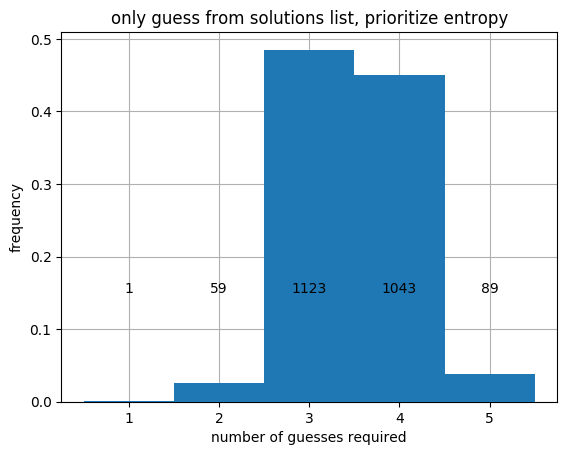

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/vtjeng/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [12]:
plot_num_turns(
    turns_sol_ent,
    title_text="only guess from solutions list, prioritize entropy",
    saved_filename="strat_using_solutions_only_prioritize_entropy.png"
)

In [13]:
prop(freqtable(turns_sol_ent))

5-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │    0.025486
3     │    0.485097
4     │     0.45054
5     │   0.0384449

In [14]:
Statistics.mean(turns_sol_ent)

3.5010799136069113

### Using only solution words as guesses, prioritizing maxsize

In [15]:
turns_sol = get_num_turns(solutions, solutions, heuristic=PRIORITIZE_MAX_GROUP_SIZE);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:20


First guess: raise
200.402913 seconds (767.77 M allocations: 32.144 GiB, 3.67% gc time, 0.00% compilation time)


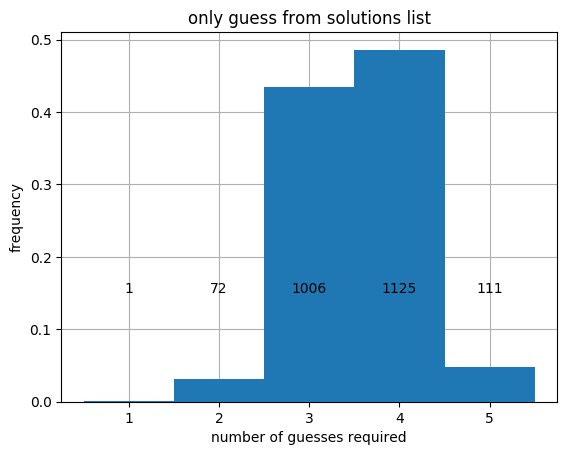

In [16]:
plot_num_turns(
    turns_sol,
    title_text="only guess from solutions list",
    saved_filename="strat_using_solutions_only.png"
)

In [17]:
prop(freqtable(turns_sol))

5-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0311015
3     │    0.434557
4     │    0.485961
5     │   0.0479482

In [18]:
Statistics.mean(turns_sol)

3.5498920086393086

### Using all possible words as guesses, prioritizing entropy

In [19]:
turns_all_ent = get_num_turns(largelist, solutions, heuristic=PRIORITIZE_ENTROPY);

Progress: 100%|█████████████████████████████████████████| Time: 0:15:16


First guess: soare
916.284499 seconds (4.24 G allocations: 174.309 GiB, 4.63% gc time)


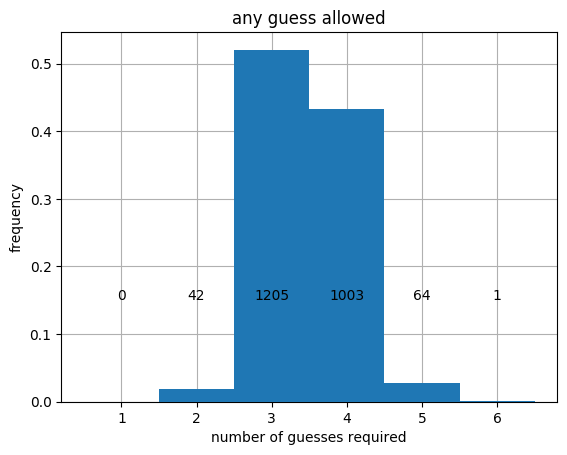

In [20]:
plot_num_turns(
    turns_all_ent,
    title_text="any guess allowed",
    saved_filename="strat_using_any_guess_prioritize_entropy.png"
)

In [21]:
prop(freqtable(turns_all_ent))

5-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
2     │   0.0181425
3     │    0.520518
4     │    0.433261
5     │   0.0276458
6     │ 0.000431965

In [22]:
Statistics.mean(turns_all_ent)

3.47170626349892

### Using all possible words as guesses, prioritizing maxsize

In [23]:
turns_all = get_num_turns(largelist, solutions, heuristic=PRIORITIZE_MAX_GROUP_SIZE);

Progress: 100%|█████████████████████████████████████████| Time: 0:14:29


First guess: raise
869.439444 seconds (4.24 G allocations: 175.869 GiB, 4.80% gc time)


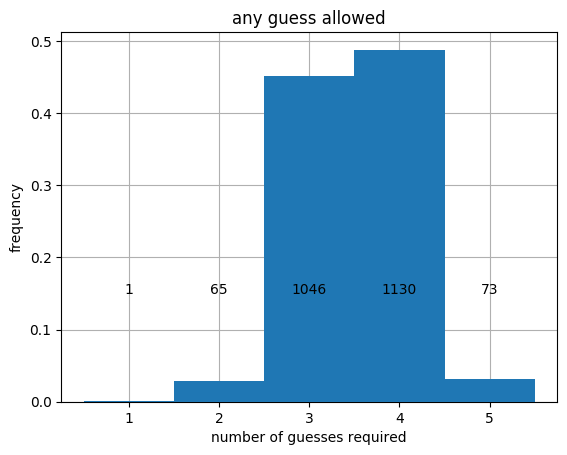

In [24]:
plot_num_turns(
    turns_all,
    title_text="any guess allowed",
    saved_filename="strat_using_any_guess.png"
)

In [25]:
prop(freqtable(turns_all))

5-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0280778
3     │    0.451836
4     │    0.488121
5     │   0.0315335

In [26]:
Statistics.mean(turns_all)

3.522246220302376